In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import idx2numpy
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize']= [20,6]

In [3]:
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate, cross_val_score, KFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,precision_score,accuracy_score,classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.pipeline import Pipeline

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from keras.callbacks import EarlyStopping

In [5]:
import mlflow
import mlflow.sklearn
import mlflow.keras
import logging
logging.getLogger("mlflow").setLevel(logging.ERROR)

In [6]:
# Training/Validation and Testing Data
tr_image_file = 'data/train-images-idx3-ubyte'
tr_label_file = 'data/train-labels-idx1-ubyte'
ts_image_file = 'data/t10k-images-idx3-ubyte'
ts_label_file = 'data/t10k-labels-idx1-ubyte'

tr_images = idx2numpy.convert_from_file(tr_image_file)
tr_labels = idx2numpy.convert_from_file(tr_label_file)
ts_images = idx2numpy.convert_from_file(ts_image_file)
ts_labels = idx2numpy.convert_from_file(ts_label_file)

tr_images.shape, tr_labels.shape, ts_images.shape, ts_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

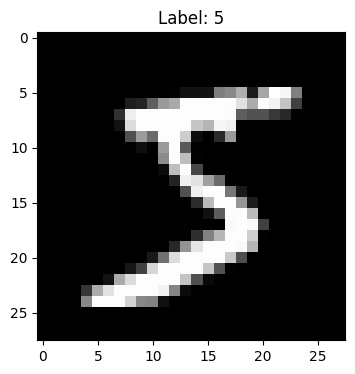

In [7]:
plt.rcParams['figure.figsize']= [10,4]

plt.imshow(tr_images[0], cmap='gray')
plt.title(f'Label: {tr_labels[0]}')
plt.show()

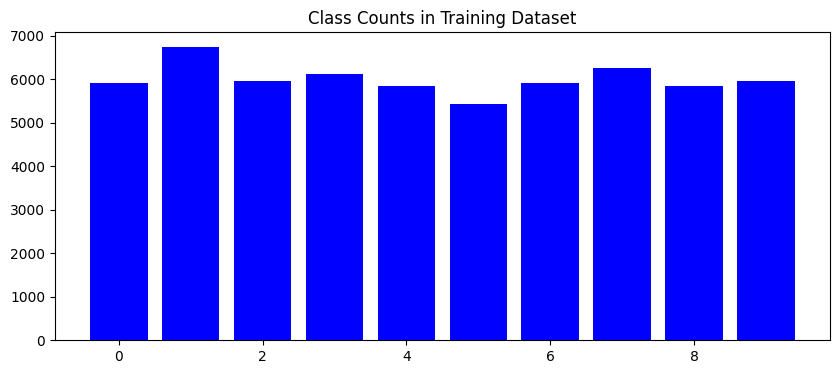

In [8]:
#Checking Class Imbalance
class_counts = Counter(tr_labels).most_common()
x = [i[0] for i in class_counts]
y = [i[1] for i in class_counts]
plt.bar(x,y,color='b')
plt.title('Class Counts in Training Dataset');

In [9]:
#Flatten Data
tr_images = tr_images.reshape(-1, 784)
ts_images = ts_images.reshape(-1, 784)

tr_images.shape, ts_images.shape

((60000, 784), (10000, 784))

In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(tr_images,tr_labels,test_size=0.1)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((54000, 784), (54000,), (6000, 784), (6000,))

In [11]:
#Standardize Data - Training/Validation
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)

In [12]:
#Standardize Data - Testing
scaler = StandardScaler()
tr_images_scaled = scaler.fit_transform(tr_images)
ts_images_scaled = scaler.transform(ts_images)

In [13]:
def build_model(num_nodes, drop_out, eta):
    
    model = Sequential()
    model.add(Dense(num_nodes, input_shape = (784,), kernel_initializer='he_uniform', activation='relu'))
    model.add(Dropout(drop_out,seed =0))
    model.add(Dense(10,activation='softmax'))

    sgd = tf.keras.optimizers.experimental.SGD(
        learning_rate=eta,
        momentum=0.0)
    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
# # Define the input signature
# input_signature = tf.TensorSpec(shape=(None, 784), dtype=tf.float32)
# @tf.function(input_signature=[input_signature])
# def predict(x):
#     return {'predictions': model(x)}
# tf.saved_model.save(model, "my_model", signatures={'serving_default': predict})

# Set the MLflow server tracking uri 
# mlflow.set_tracking_uri("http://localhost:5000")


def Log_training_validation_expts(num_nodes, drop_out, eta,
                                  training_accuracy, validation_accuracy):
    
    with mlflow.start_run() as run:
        # Log parameters
        mlflow.log_param("num_nodes", num_nodes)
        mlflow.log_param("dropout", drop_out)
        mlflow.log_param("learning_rate", eta)

        # Log metrics
        mlflow.log_metric("training_accuracy", training_accuracy)
        mlflow.log_metric("validation_accuracy", validation_accuracy)
        
        return 1

In [15]:
#Parameters to optimize. Through systematic experimentation already gotten a feel for other params, such as 
# number of layers, batch_size, epoch, activation_funcn and optimizers, etc
params = {'number_of_nodes': [64,128,256,512],
         'drop_out': [0.0,0.1,0.2,0.3,0.4],
         'eta': [0.01, 0.025, 0.05, 0.075, 0.1]}

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=False)
mlflow.set_experiment("minst-mlp-dev")

for n in tqdm(params['number_of_nodes']):
    for d in params['drop_out']:
        for e in params['eta']:
            temp_model = build_model(n,d,e)
 
            history = temp_model.fit(X_tr_scaled, y_tr, validation_data=(X_val_scaled, y_val),
                                     batch_size = 256, epochs=30, 
                                     callbacks=[early_stopping], verbose=False)

            training_accuracy = history.history['accuracy'][-1]
            validation_accuracy = history.history['val_accuracy'][-1]
            Log_training_validation_expts(n, d, e, training_accuracy, validation_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:12:12<00:00, 1083.04s/it]


 - ### Results

In [17]:
from mpl_toolkits.mplot3d import Axes3D

In [63]:
all_runs = mlflow.search_runs()
all_runs.shape

(100, 15)

In [64]:
relev_cols = ['metrics.validation_accuracy',
              'params.num_nodes','params.dropout','params.learning_rate',
             'metrics.training_accuracy']
all_runs.head()[relev_cols]

,metrics.validation_accuracy,params.num_nodes,params.dropout,params.learning_rate,metrics.training_accuracy
0,0.968667,512,0.4,0.1,0.974315
1,0.973833,512,0.4,0.075,0.978907
2,0.967833,512,0.4,0.05,0.972315
3,0.961667,512,0.4,0.025,0.963463
4,0.949833,512,0.4,0.01,0.941315


In [70]:
#Check top-5 Validation Accuracy paramater values
all_runs.sort_values(by='metrics.validation_accuracy',ascending=False)[relev_cols].iloc[:10]

,metrics.validation_accuracy,params.num_nodes,params.dropout,params.learning_rate,metrics.training_accuracy
40,0.975167,256,0.1,0.1,0.992796
25,0.975167,256,0.4,0.1,0.980204
10,0.975000,512,0.2,0.1,0.989852
1,0.973833,512,0.4,0.075,0.978907
21,0.973833,512,0.0,0.075,0.998037
16,0.973500,512,0.1,0.075,0.991833
20,0.973167,512,0.0,0.1,0.999241
35,0.972667,256,0.2,0.1,0.985000
46,0.972500,256,0.0,0.075,0.996556
61,0.972500,128,0.2,0.075,0.976667


From the above list it appears, the network with 128 nodes (listed last above) appears to be the most logical choice. The gain in predictive performance is less than 0.5% and that wouldn't be worth doubling the network parameters.

 - ### Log Final Performance with Optimal Params

In [73]:
model = Sequential()
model.add(Dense(128, input_shape = (784,), kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.2,seed =0))
model.add(Dense(10,activation='softmax'))

sgd = tf.keras.optimizers.experimental.SGD(
                        learning_rate=0.075,
                        momentum=0.0)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 128)               100480    
                                                                 
 dropout_100 (Dropout)       (None, 128)               0         
                                                                 
 dense_201 (Dense)           (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
history = model.fit(X_tr_scaled, y_tr, validation_data=(X_val_scaled, y_val),
                  batch_size = 256, epochs=30, 
                  callbacks=[early_stopping], verbose=False)

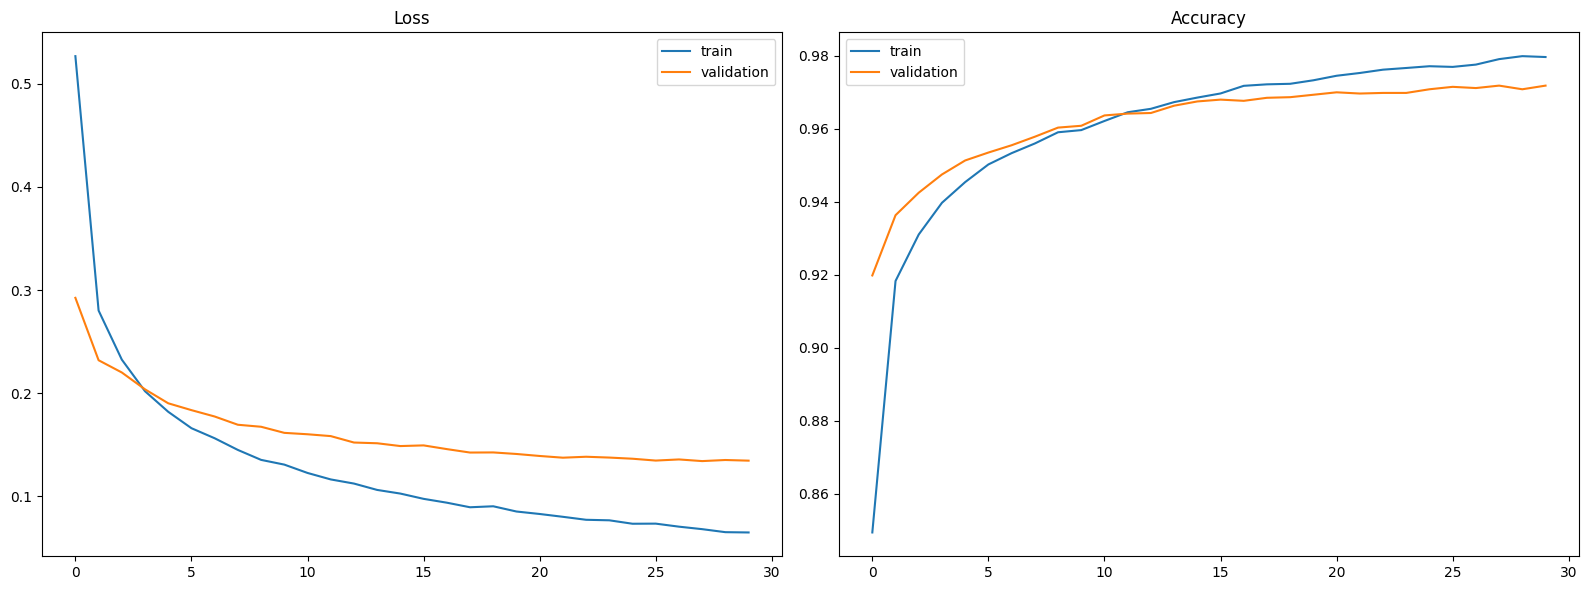

In [75]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_title('Loss')
# axs[0].set_ylim(0, 1)
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.tight_layout();

In [76]:
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]

training_accuracy, validation_accuracy

(0.9796666502952576, 0.971833348274231)

In [77]:
test_loss, test_accuracy = model.evaluate(ts_images_scaled, ts_labels)
test_loss, test_accuracy

313/313 [==============================] - 0s 1ms/step - loss: 0.1227 - accuracy: 0.9713


(0.1226535364985466, 0.9713000059127808)

In [ ]:
mlflow.set_experiment("minst-mlp-dev")
with mlflow.start_run() as run:
    # Log parameters
    mlflow.log_param("num_nodes", 128)
    mlflow.log_param("dropout", 0.2)
    mlflow.log_param("learning_rate", 0.075)

    # Log metrics
    mlflow.log_metric("training_accuracy", training_accuracy)
    mlflow.log_metric("validation_accuracy", validation_accuracy)
    mlflow.log_metric("test_accuracy", test_accuracy)
    
    #Log artficats
    mlflow.keras.model